In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
from jax.tree_util import Partial

import hugegp as hg

import matplotlib.pyplot as plt
import time

key = jr.key(137)

In [2]:
# Generate points
n_points = 100_000
key, k1 = jr.split(key)
points = jr.normal(k1, (n_points, 2))

# Compute neighbors
graph = hg.build_kd_graph(points, k=4, start_level=10)
points = graph[0]

In [3]:
# Random excitations
key, k1 = jr.split(key)
xi = jr.normal(k1, (n_points,))

values = hg.generate_refine(graph, xi, cuda=False).block_until_ready()
values_cuda = hg.generate_refine(graph, xi, cuda=True).block_until_ready()

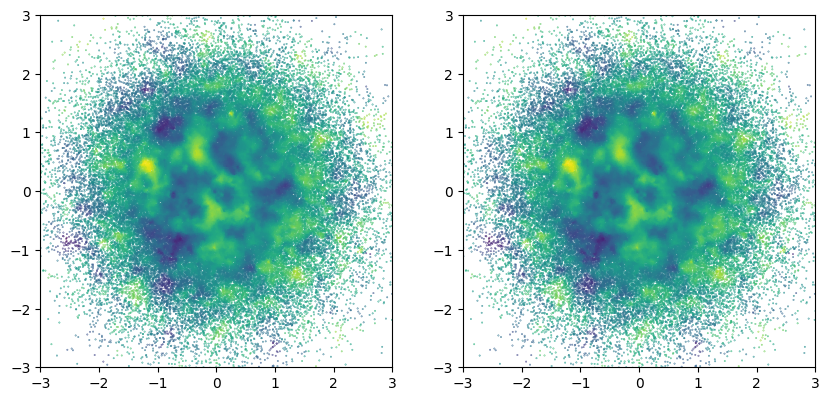

In [4]:
# Plot
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
axes[0].scatter(*points.T, c=values, s=0.1, cmap='viridis')
axes[1].scatter(*points.T, c=values_cuda, s=0.1, cmap='viridis')
for ax in axes:
    ax.set(aspect='equal', xlim=(-3, 3), ylim=(-3, 3))
plt.show()

In [5]:
func = Partial(hg.generate_refine, graph)
func_cuda = Partial(hg.generate_refine, graph, cuda=True)

_, dv = jax.jvp(func, (xi,), (jnp.ones_like(xi),))
dv[1023:]

Array([1.8863125, 2.231307 , 2.286205 , ..., 4.0493803, 3.934532 ,
       2.9782681], dtype=float32)

In [6]:
_, dv_cuda = jax.jvp(func_cuda, (xi,), (jnp.ones_like(xi),))
dv[1023:]

Array([1.8863125, 2.231307 , 2.286205 , ..., 4.0493803, 3.934532 ,
       2.9782681], dtype=float32)

In [7]:
primals_out, vjp_func = jax.vjp(func, xi)
vjp_eval = vjp_func(jnp.ones_like(xi))
vjp_eval[0][1023:]

Array([3.22391739e+01, 4.45103760e+01, 3.30903130e+01, ...,
       1.43088065e-02, 2.52588224e-02, 1.59459524e-02], dtype=float32)

In [8]:
primals_out, vjp_func = jax.vjp(func_cuda, xi)
vjp_eval_cuda = vjp_func(jnp.ones_like(xi))
vjp_eval_cuda[0][1023:]

Array([3.22391739e+01, 4.45103683e+01, 3.30902901e+01, ...,
       1.43088065e-02, 2.52588224e-02, 1.59440842e-02], dtype=float32)

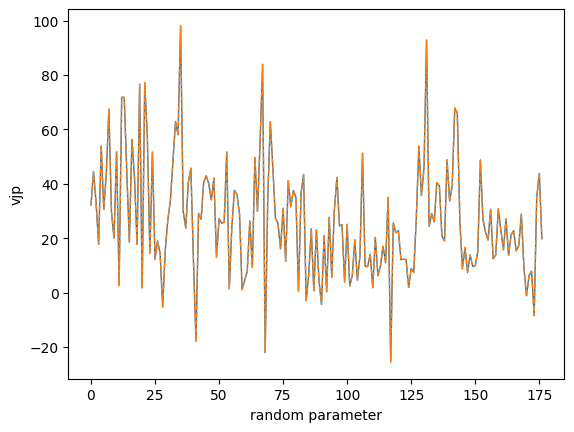

In [9]:
plt.plot(vjp_eval[0][1023:1200:], lw=1)
plt.plot(vjp_eval_cuda[0][1023:1200], lw=1, ls='--')
plt.gca().set(xlabel='random parameter', ylabel='vjp')
plt.show()

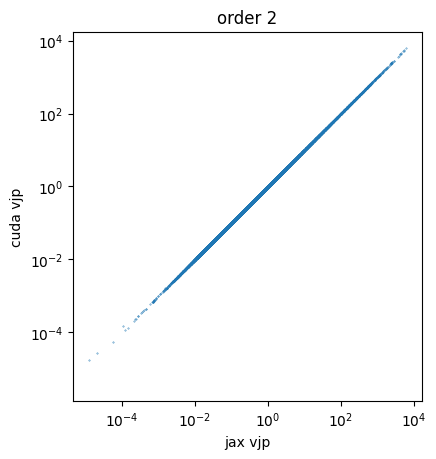

In [10]:
plt.scatter(vjp_eval[0], vjp_eval_cuda[0], s=0.1)
plt.gca().set(aspect='equal', xscale='log', yscale='log', xlabel='jax vjp', ylabel='cuda vjp', title='order 2')
plt.show()

# Test gradient optimization


In [54]:
import optax
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [148]:
# Generate points
n_points = 10_000
key, k1 = jr.split(key)
points = jr.normal(k1, (n_points, 2))

# Compute neighbors
graph = hg.build_kd_graph(points, k=4, start_level=10)
points = graph[0]

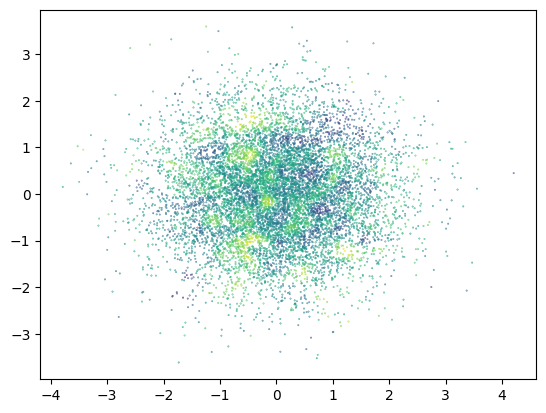

In [178]:
# Generate truth
key, k1 = jr.split(key)
xi_true = jr.normal(k1, (n_points,))
values_true = hg.generate_refine(graph, xi_true, cuda=True).block_until_ready()

plt.scatter(*points.T, c=values_true, s=0.1, cmap='viridis')

In [179]:
# Set up optimization
optimizer = optax.adam(0.03)
key, k1 = jr.split(key)
xi_guess = jr.normal(k1, (n_points,))

In [214]:
# Mean squared error loss
def loss_fn(xi):
    values = hg.generate_refine(graph, xi, cuda=True)
    return jnp.sum(jnp.square(values - values_true))

# Optimization step
def step(carry):
    xi, optimizer_state = carry
    loss, grad = jax.value_and_grad(loss_fn)(xi)
    updates, optimizer_state = optimizer.update(grad, optimizer_state)
    xi = optax.apply_updates(xi, updates)
    return (xi, optimizer_state), loss

In [236]:
# Optimize!
xi = xi_guess
optimizer_state = optimizer.init(xi_guess)
loss_hist = []
values_hist = []

for i in tqdm(range(30)):
    (xi, optimizer_state), loss = step((xi, optimizer_state))
    if i==0: print(xi)
    loss_hist.append(float(loss))
    values_hist.append(hg.generate_refine(graph, xi, cuda=True))

values = hg.generate_refine(graph, xi, cuda=True).block_until_ready()

 10%|█         | 3/30 [00:00<00:01, 19.99it/s]

[ 2.3746662   0.0969982   0.7547975  ...  1.4206702  -0.01722931
  0.7209626 ]


100%|██████████| 30/30 [00:01<00:00, 20.51it/s]


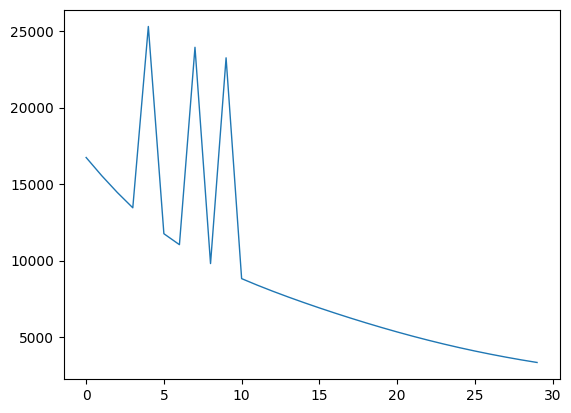

In [237]:
plt.plot(loss_hist, lw=1)

In [172]:
# Animate optimization
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
axes[0].scatter(*points.T, c=values_true, s=1, cmap='viridis', vmin=-3, vmax=3)
s = axes[1].scatter(*points.T, c=values_hist[0], s=1, cmap='viridis', vmin=-3, vmax=3)
for ax in axes:
    ax.set(aspect='equal', xlim=(-3, 3), ylim=(-3, 3))

def update(i):
    s.set_array(values_hist[i])
    return s,

ani = FuncAnimation(fig, update, frames=jnp.arange(0, len(values_hist), 5), blit=True, interval=1000/10)
plt.close()
HTML(ani.to_html5_video())

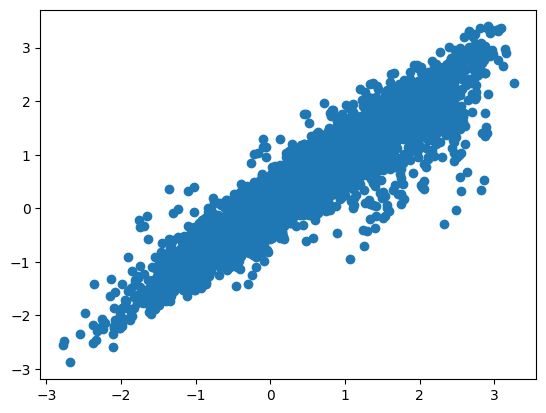

In [155]:
plt.scatter(values_true, values)

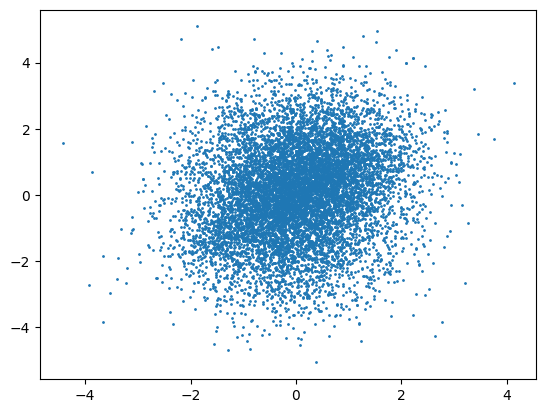

In [156]:
plt.scatter(xi_true, xi, s=1)